In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [2]:
df = wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [6]:
df.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

How many different cases are there, by department?

In [9]:
df.groupBy('department').count().sort('count').show()

+--------------------+------+
|          department| count|
+--------------------+------+
|        City Council|    33|
|    Customer Service|  2849|
|        Metro Health|  5163|
|  Parks & Recreation| 19907|
|Trans & Cap Impro...| 96193|
|Animal Care Services|116915|
|         Solid Waste|279270|
|DSD/Code Enforcement|321374|
+--------------------+------+



Does the percentage of cases that are late vary by department?

In [15]:
dept_late = df.crosstab("department", "case_late")

In [19]:
dept_late.dtypes

[('department_case_late', 'string'), ('false', 'bigint'), ('true', 'bigint')]

In [21]:
dept_late.select(
    dept_late.department_case_late, 
    (dept_late.true/(dept_late.true + dept_late.false)).alias("Percentage of Cases Late")
).show()

+--------------------+------------------------+
|department_case_late|Percentage of Cases Late|
+--------------------+------------------------+
|        City Council|                     0.0|
|         Solid Waste|      0.1179682744297633|
|Trans & Cap Impro...|     0.05625149439148379|
|  Parks & Recreation|     0.19073692670919776|
|    Customer Service|      0.7055107055107055|
|DSD/Code Enforcement|      0.0816338596152769|
|Animal Care Services|     0.19908480520035923|
|        Metro Health|     0.16056556265736974|
+--------------------+------------------------+



On average, how late are the late cases by department?

In [23]:
df.filter(df.num_days_late>0).groupBy('department').mean('num_days_late').show()

+--------------------+------------------+
|          department|avg(num_days_late)|
+--------------------+------------------+
|         Solid Waste| 7.186821906120906|
|Animal Care Services|23.458633245820135|
|Trans & Cap Impro...| 10.60306468031694|
|  Parks & Recreation|22.348910457867508|
|    Customer Service| 87.68385942150395|
|        Metro Health| 6.543813315547647|
|DSD/Code Enforcement|49.384287053588935|
+--------------------+------------------+



What is the service type that is the most late? 

In [32]:
df.filter(df.num_days_late>0).groupBy(
    'service_request_type').mean(
    'num_days_late').sort(desc(
    "avg(num_days_late)")).first().service_request_type

'Zoning: Recycle Yard'

Just for Parks & Rec?

In [33]:
df.filter(df.num_days_late>0).where(df['department'] == 'Parks & Recreation').groupBy(
    'service_request_type').mean(
    'num_days_late').sort(desc(
    "avg(num_days_late)")).first().service_request_type

'Amenity Park Improvement'

For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [39]:
df.where(df['department'] == "DSD/Code Enforcement").groupBy('service_request_type').count().sort(desc('count')).head(5)

[Row(service_request_type='Overgrown Yard/Trash', count=65895),
 Row(service_request_type='Bandit Signs', count=32910),
 Row(service_request_type='Front Or Side Yard Parking', count=28794),
 Row(service_request_type='Junk Vehicle On Private Property', count=21473),
 Row(service_request_type='Alley-Way Maintenance', count=20214)]

Does whether or not its a weekend matter for when a case is opened/closed?

In [41]:
#Create a sparkDF that is just the department column, the date opened/closed columns reduced down to calendar day.
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

In [46]:
cases_by_day.groupBy('case_opened_date').count().sort(desc('count')).head(5)

[Row(case_opened_date='2017-02-21', count=2438),
 Row(case_opened_date='2018-08-07', count=2405),
 Row(case_opened_date='2018-04-17', count=2388),
 Row(case_opened_date='2017-02-28', count=2370),
 Row(case_opened_date='2018-03-26', count=2349)]

In [55]:
blob = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
)

In [47]:
#Creates a panda series
#  From the previous sparkDF, they're grouped by their open date, and each record with that open date is counted. The
#  count is the value.
#  That sorted, nulldropped groupby SparkDF is made into a PandasDF, and the case_opened_date (which is the groups)
#  is turned into a pandas datetime type, which is then set as the index.
#  WTF is that ['count'] at the end do?
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
#That ['count'] is specifically naming the only column in the dataframe made by .topandas
#Without the ['count'], a DF would be assigned, rather than a Series

In [68]:
blob

,count,Day_Of_Week
case_opened_date,,
2017-01-01,155,Sunday
2017-01-02,1397,Monday
2017-01-03,1760,Tuesday
2017-01-04,1613,Wednesday
2017-01-05,1791,Thursday
...,...,...
2018-08-04,665,Saturday
2018-08-05,319,Sunday
2018-08-06,2071,Monday


In [63]:
blob['Day_Of_Week'] = blob.index.strftime("%A")

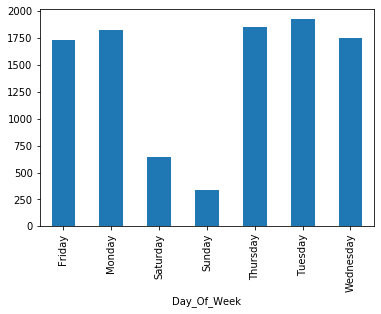

In [75]:
blob.groupby('Day_Of_Week')['count'].mean().plot('bar')

In [59]:
type(cases_opened_by_day)

pandas.core.series.Series

In [62]:
cases_opened_by_day.index[0].strftime("%A")

'Sunday'

On average, how many cases are opened a day for the Customer Service department?

In [78]:
customer_service = cases_by_day.filter(cases_by_day.department == 'Customer Service')

In [82]:
cs_df = customer_service.toPandas()

In [89]:
cs_df = cs_df.assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))

In [90]:
cs_df = cs_df.assign(case_closed_date=lambda df: pd.to_datetime(df.case_opened_date))

In [93]:
type(cs_df.case_opened_date.max())

pandas._libs.tslibs.timestamps.Timestamp

In [96]:
time_range = cs_df.case_opened_date.max() - cs_df.case_opened_date.min()

In [97]:
time_range.days

582

In [98]:
customer_service.count()/time_range.days

4.8951890034364265

Does the number of service requests for the solid waste department vary by day of the week?

In [99]:
solid_waste = cases_by_day.filter(cases_by_day.department == 'Solid Waste')

In [105]:
solid_waste.head(5)

[Row(department='Solid Waste', case_opened_date='2018-01-01', case_closed_date='2018-01-02'),
 Row(department='Solid Waste', case_opened_date='2018-01-01', case_closed_date='2018-01-02'),
 Row(department='Solid Waste', case_opened_date='2018-01-01', case_closed_date='2018-01-02'),
 Row(department='Solid Waste', case_opened_date='2018-01-01', case_closed_date='2018-01-02'),
 Row(department='Solid Waste', case_opened_date='2018-01-01', case_closed_date='2018-01-02')]

In [123]:
solid_waste_pandas = (
    solid_waste
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)

In [124]:
DoW = solid_waste_pandas.index.strftime("%A")

In [127]:
DoW

Index(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'Monday', 'Tuesday',
       ...
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype='object', length=585)

In [130]:
solid_waste_pandas['DoW'] = solid_waste_pandas.index.strftime("%A")

In [125]:
solid_waste_pandas = pd.DataFrame(solid_waste_pandas)

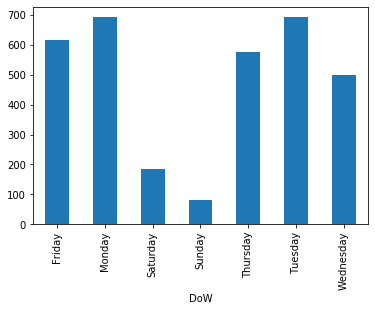

In [133]:
solid_waste_pandas.groupby('DoW')['count'].mean().plot('bar')